<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Artificial Intelligence and Machine Learning</center></font></h1>
<h1><center>Deep Neural Networks: Bank Churn Prediction</center></h1>
<h4><center>Author: Enrique Martin Sanchez</center></h4>

# Description

## Background and Context

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

## Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

## Data Description

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

## Data Dictionary

- CustomerId: Unique ID which is assigned to each customer
- Surname: Last name of the customer 
- CreditScore: It defines the credit history of the customer.  
- Geography: A customer’s location    
- Gender: It defines the Gender of the customer   
- Age: Age of the customer     
- Tenure: Number of years for which the customer has been with the bank
- NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
- Balance: Account balance
- HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
- EstimatedSalary: Estimated salary 
- isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
- Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
                    0=No ( Customer did not leave the bank )

                    1=Yes ( Customer left the bank )

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Input, Dropout,BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import random
from tensorflow.keras import backend
from tensorflow import keras
from tensorflow.keras import layers


%matplotlib inline

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.4f}'.format

import warnings
warnings.filterwarnings('ignore')

# Support Functions

In [2]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [3]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = "{:,.0f}".format(
                p.get_height()
              )  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [4]:
### Function to plot distributions


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [5]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [6]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))



    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    
    if title:
        plt.title(title)

# EDA - Exploratory data anlyisis

## Understanding the data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data = pd.read_csv('/content/drive/MyDrive/Data Science/Courses/AIML University of Texas/7. Introduction to Neural Networks/Project 7: Deep Neural Networks - Bank Churn Prediction - EMS/Churn.csv')
df = data.copy()

In [9]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0000,1,1,1,"101,348.8800",1
1,2,15647311,Hill,608,Spain,Female,41,1,"83,807.8600",1,0,1,"112,542.5800",0
2,3,15619304,Onio,502,France,Female,42,8,"159,660.8000",3,1,0,"113,931.5700",1
3,4,15701354,Boni,699,France,Female,39,1,0.0000,2,0,0,"93,826.6300",0
4,5,15737888,Mitchell,850,Spain,Female,43,2,"125,510.8200",1,1,1,"79,084.1000",0


In [10]:
df.shape

(10000, 14)

**Insights**
- There are 14 columns
- There are 10,000 rows of data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Insights**
- There are 3 object columns
- There are 11 numerical columns
- There are no missing data

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
RowNumber,"10,000.0000","5,000.5000","2,886.8957",1.0000,"2,500.7500","5,000.5000","7,500.2500","10,000.0000"
CustomerId,"10,000.0000","15,690,940.5694","71,936.1861","15,565,701.0000","15,628,528.2500","15,690,738.0000","15,753,233.7500","15,815,690.0000"
CreditScore,"10,000.0000",650.5288,96.6533,350.0000,584.0000,652.0000,718.0000,850.0000
Age,"10,000.0000",38.9218,10.4878,18.0000,32.0000,37.0000,44.0000,92.0000
Tenure,"10,000.0000",5.0128,2.8922,0.0000,3.0000,5.0000,7.0000,10.0000
Balance,"10,000.0000","76,485.8893","62,397.4052",0.0000,0.0000,"97,198.5400","127,644.2400","250,898.0900"
NumOfProducts,"10,000.0000",1.5302,0.5817,1.0000,1.0000,1.0000,2.0000,4.0000
HasCrCard,"10,000.0000",0.7055,0.4558,0.0000,0.0000,1.0000,1.0000,1.0000
IsActiveMember,"10,000.0000",0.5151,0.4998,0.0000,0.0000,1.0000,1.0000,1.0000
EstimatedSalary,"10,000.0000","100,090.2399","57,510.4928",11.5800,"51,002.1100","100,193.9150","149,388.2475","199,992.4800"


**Insights**
- Row number seems to be a unique identifier
- CustomerId seems to be a unique identifier
- CreditScore ranges from 350 to 850 with mean of 650
- Age ranges from 18 to 92 with mean of 38.9 (right skewed)
- Tenure goes from 0 to 10 with mean of 5
- Balance range from 0 to 251k with mean of 76k (right skewed) 25% with $0 balance
- NumOfProducts ranges from 1 to 4 mean of 1.5
- HasCrCard categorical (0 or 1)
- IsActiveMember categorical (0 or 1)
- EstimatedSalary goes from 11.5k to 200k (right skewed)
- Exited target variable (0 or 1) imbalanced Q1 to Q3 = 0
- We can see that numerical variables ought to be standarized since their magnitudeas are quite different

In [13]:
df[df.duplicated()].Exited.count()

0

**Insights**
- There is no duplicated rows

In [14]:
round(df.isnull().sum() / df.isnull().count() * 100, 2)

RowNumber         0.0000
CustomerId        0.0000
Surname           0.0000
CreditScore       0.0000
Geography         0.0000
Gender            0.0000
Age               0.0000
Tenure            0.0000
Balance           0.0000
NumOfProducts     0.0000
HasCrCard         0.0000
IsActiveMember    0.0000
EstimatedSalary   0.0000
Exited            0.0000
dtype: float64

**Insights**
- There are no missing data

## Univarite analysis

**RowNumber and CustomerId**

In [15]:
df.RowNumber.nunique()

10000

In [16]:
df.CustomerId.nunique()

10000

In [17]:
df.drop(columns=['RowNumber','CustomerId'], inplace=True)

**Insights**
- Both RowNumber and CustomerId have 10,000 unique values (they are unique identifiers)
- We drop them both

**Surname**

In [18]:
df.Surname.sample(10)

2770     Gardener
6938      Azikiwe
1729     Johnston
7090     Cattaneo
2579     Ozoemena
4014    Evdokimov
5409         Howe
8761       Parkin
8607          Jen
5928        Hsieh
Name: Surname, dtype: object

In [19]:
df.Surname.nunique()

2932

In [20]:
df.drop(columns=['Surname'], inplace=True)

**Insights**
- This column will not be used for training our model, so we drop it

**CreditScore**

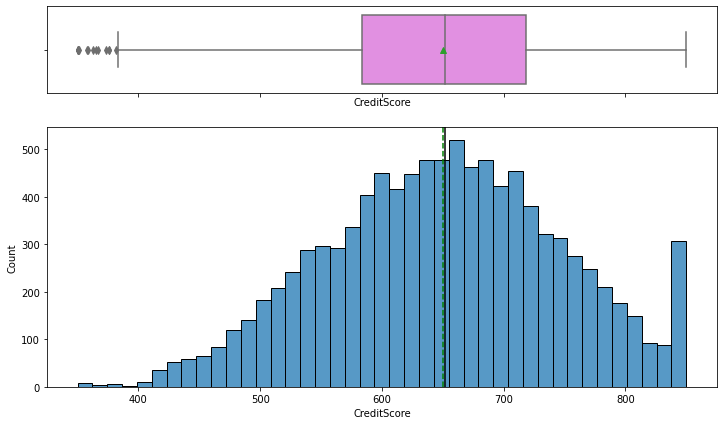

In [21]:
histogram_boxplot(data=df, feature='CreditScore')

In [22]:
df[df.CreditScore < 400].CreditScore.count()

19

**Insights**
- It is close to a normal distribution with a lot of people at maximum score of 850
- There are some outliers (dont seem to be errors since the number are low (19))

**Geography**

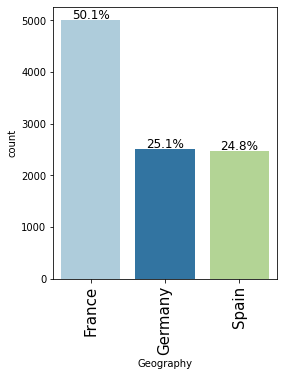

In [23]:
labeled_barplot(data=df, feature='Geography', perc=True)

**Insights**
- 50% of customers live in France
- 25% in Germany and the rest in Spain

**Gender**

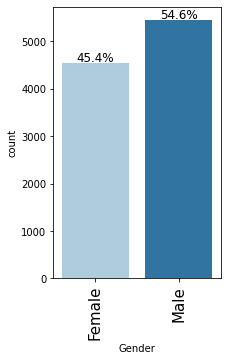

In [24]:
labeled_barplot(data=df, feature='Gender', perc=True)

**Insights**
- 45% Females
- 55% Males

**Age**

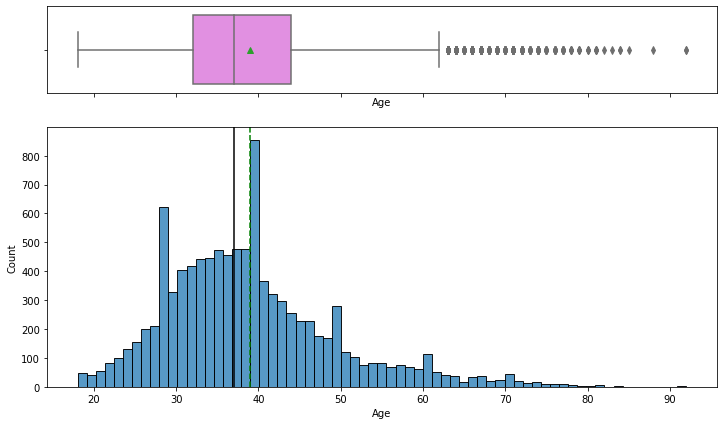

In [25]:
histogram_boxplot(data=df, feature='Age')

In [26]:
df[df.Age > 61].Age.count()

411

**Insights**
- Distribution is close to normal 
- There are a some outliers on the right side, they do not seem to be errors since thaa bank can actualy have a 92 year old customer, we will not treat them

**Tenure**

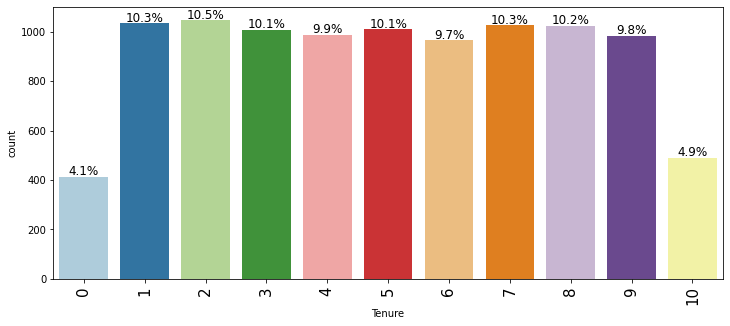

In [27]:
labeled_barplot(data=df, feature='Tenure', perc=True)

**insights** 
- customers with 10 years and customers with less than 11 year with the bank are between 4 and 5%
- The rest of the customers are equaly distributed from 1 to 9 years

**Balance**


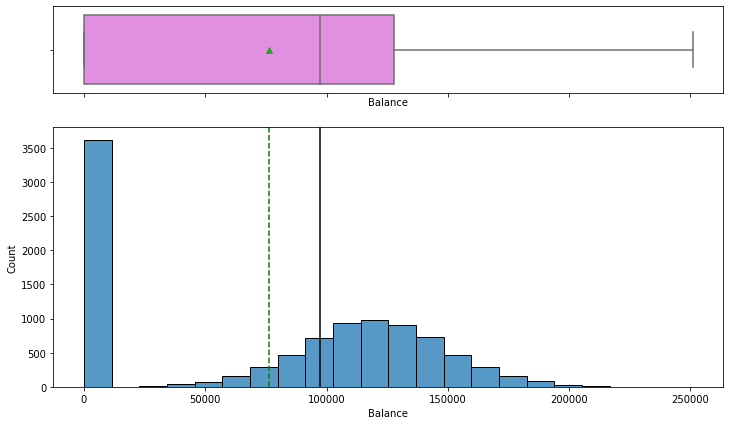

In [28]:
histogram_boxplot(data=df, feature='Balance')

**Insights**
- More than 35% of customers have zero balance
- The rest are normaly distributed

**NumOfProducts**

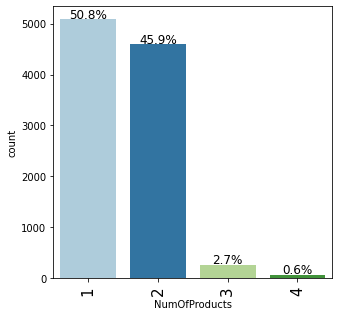

In [29]:
labeled_barplot(data=df, feature='NumOfProducts', perc=True)

**Insights**
- 51% of customers have 1 product
- 46% have 2 products
- customers with 3 and 4 products are scarce 

**HasCrCrad**

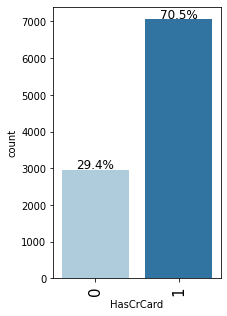

In [30]:
labeled_barplot(data=df, feature='HasCrCard', perc=True)

**Insights**
- 30% of customers does not have a credit card
- 70% of customers own a credit card

**IsActiveMember**

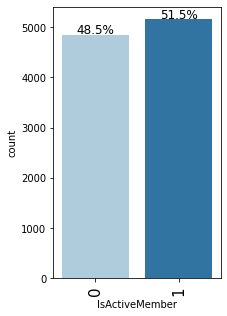

In [31]:
labeled_barplot(data=df, feature='IsActiveMember', perc=True)

**Insights** 
- 48% of customers are not active
- 52% of customers are active

**EstimatedSalary**

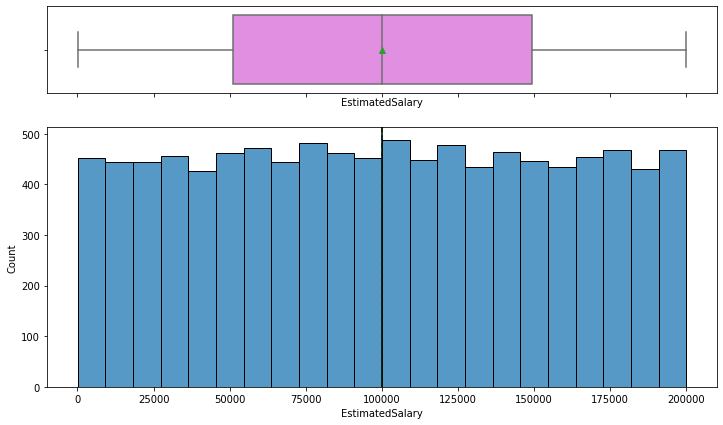

In [32]:
histogram_boxplot(data=df, feature='EstimatedSalary')

**Insights**
- There is a constant distribution of salary
- There are not outlayers

**Exited**

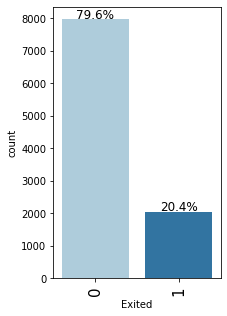

In [33]:
labeled_barplot(data=df, feature='Exited', perc=True)

**Insights**
- There is an imbalance in target variable
- 79.6% of customers did not leave the bank
- 20.4% of customers leave the bank

## Bivariate analysis

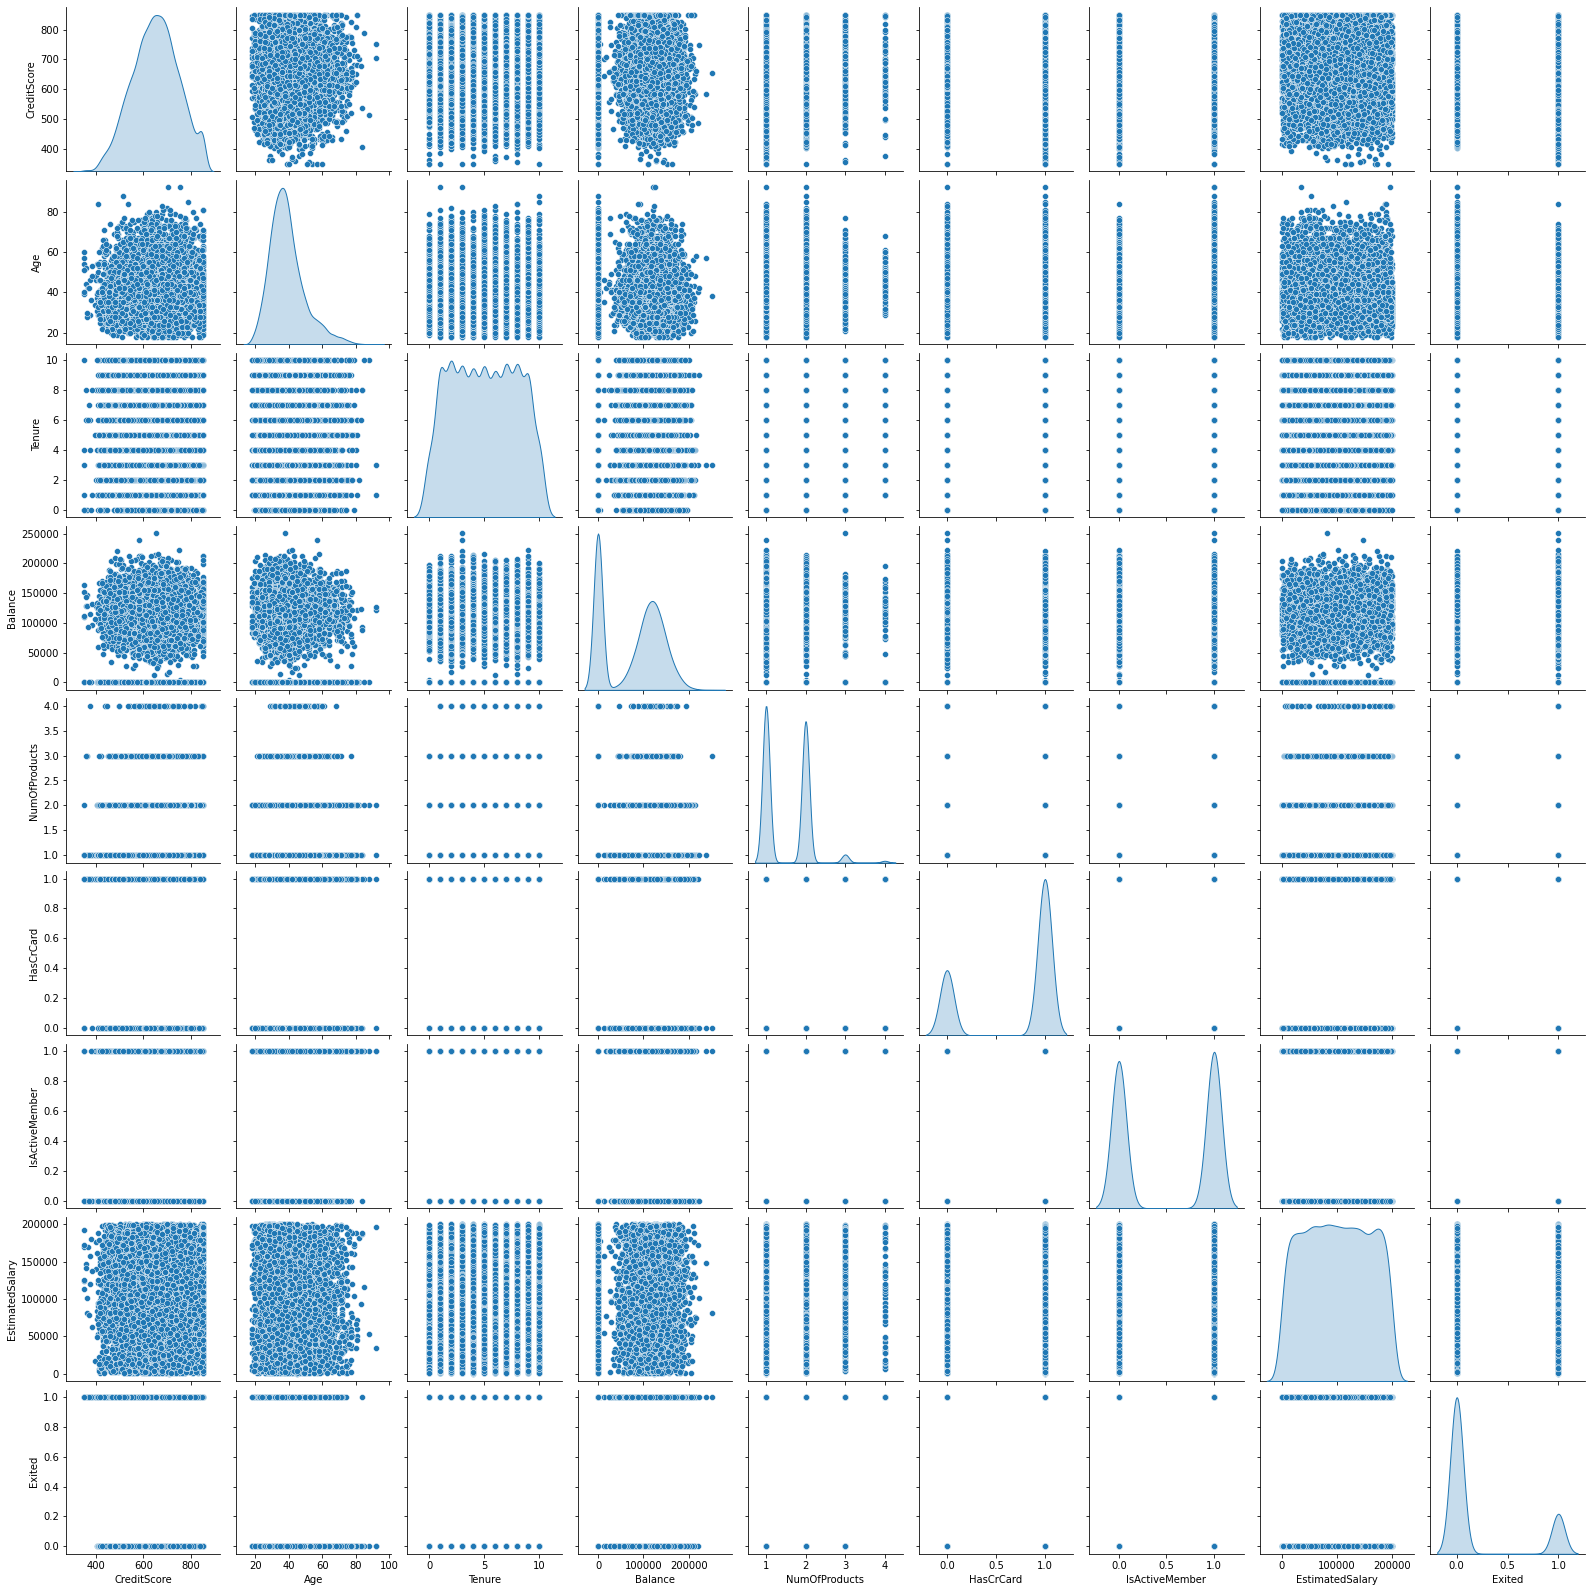

In [34]:
sns.pairplot(data=df, diag_kind='kde')

**Insights**
- There are no correlations between the data

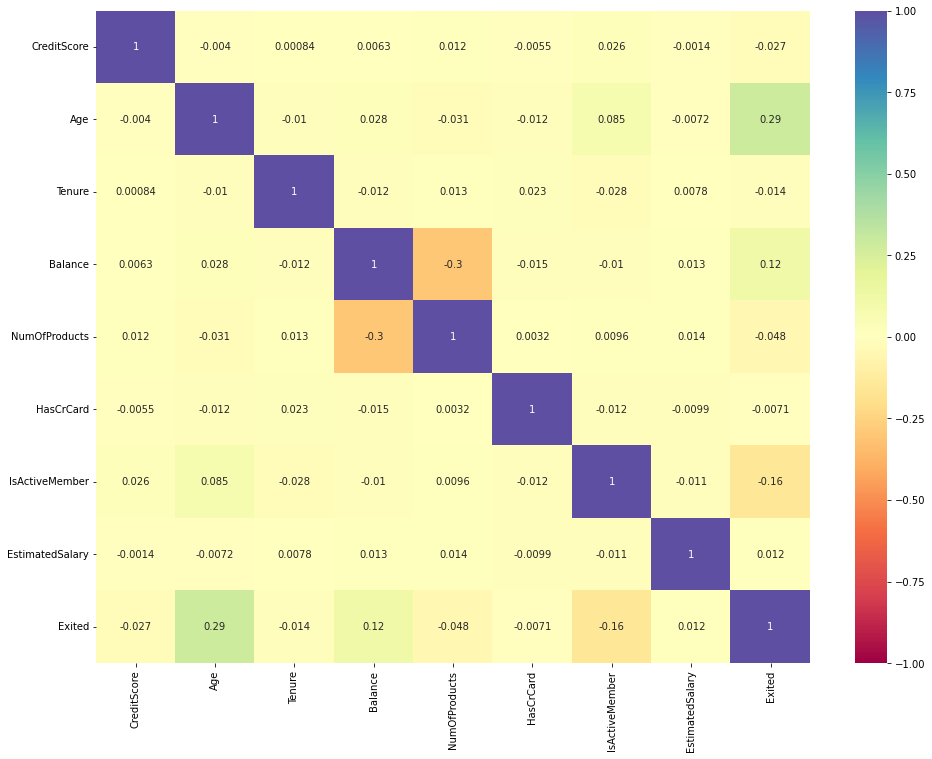

In [35]:
fig = plt.figure(figsize=(16,12))
sns.heatmap(df.corr(), annot=True, cmap='Spectral', vmin=-1, vmax=1)

**Insights**
- There is no correleation between the data

### Target vs other features

**CreditScore**

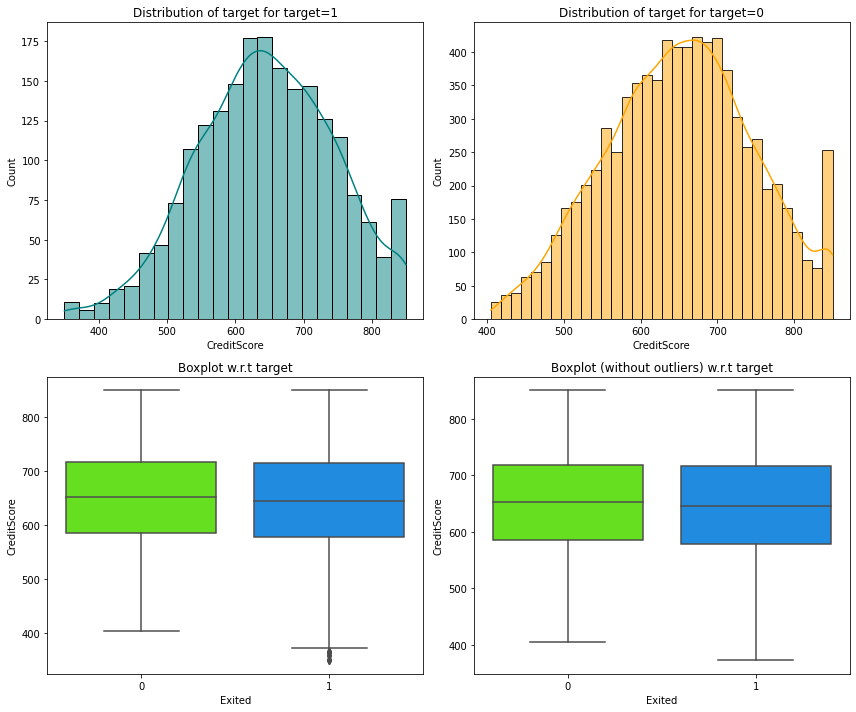

In [36]:
distribution_plot_wrt_target(data=df, predictor='CreditScore', target='Exited')

**Insights**
- Both distributions are the same
- CreditScore is the same for customers who exited and who remained at the bank

**Geography**

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
------------------------------------------------------------------------------------------------------------------------


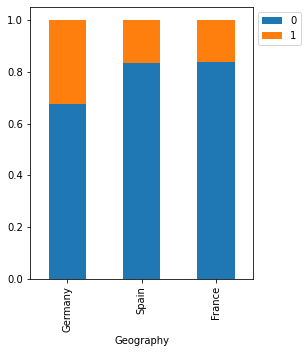

In [37]:
stacked_barplot(data=df, predictor='Geography', target='Exited')

**Insights**
- German customers tend to leave the bank more often than spanish or french ones

**Gender**

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
------------------------------------------------------------------------------------------------------------------------


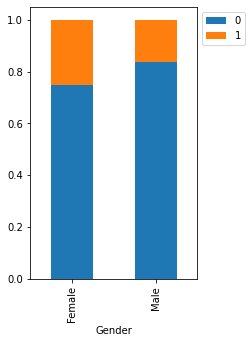

In [38]:
stacked_barplot(data=df, predictor='Gender', target='Exited')

**Insights**
- Female customers leave the bank more often than males

**Tenure**

Exited     0     1    All
Tenure                   
All     7963  2037  10000
1        803   232   1035
3        796   213   1009
9        771   213    984
5        803   209   1012
4        786   203    989
2        847   201   1048
8        828   197   1025
6        771   196    967
7        851   177   1028
10       389   101    490
0        318    95    413
------------------------------------------------------------------------------------------------------------------------


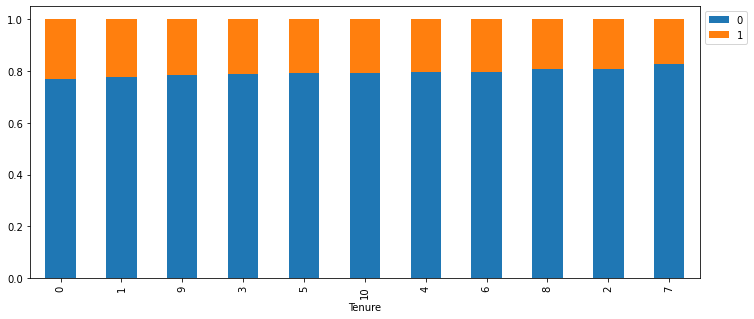

In [39]:
stacked_barplot(data=df, predictor='Tenure', target='Exited')

**Insights**
- New customers tend to leave the bank a little more often than customers with more years of relation with the bank

**Balance**

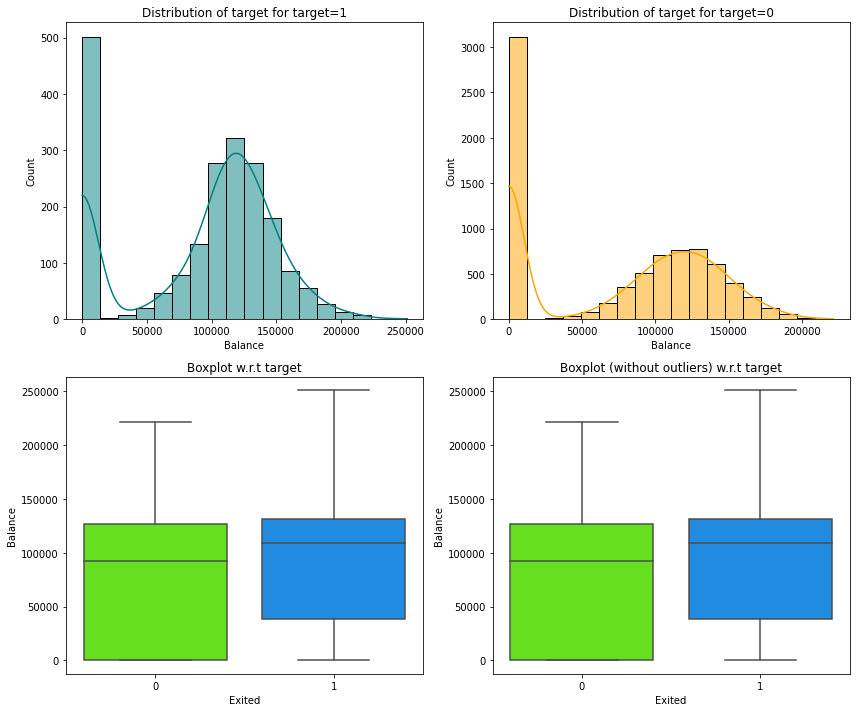

In [40]:
distribution_plot_wrt_target(data=df, predictor='Balance', target='Exited')

**Insights**
- Customers who exited the bank had higher balance than thos who stayed

**NumOfProducts**

Exited            0     1    All
NumOfProducts                   
All            7963  2037  10000
1              3675  1409   5084
2              4242   348   4590
3                46   220    266
4                 0    60     60
------------------------------------------------------------------------------------------------------------------------


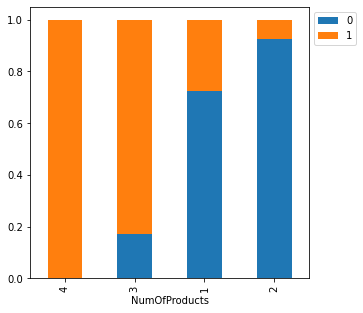

In [41]:
stacked_barplot(data=df, predictor='NumOfProducts', target='Exited')

In [42]:
df[df.NumOfProducts == 4].Exited.value_counts(normalize=True)

1   1.0000
Name: Exited, dtype: float64

In [43]:
df[df.NumOfProducts == 3].Exited.value_counts(normalize=True)

1   0.8271
0   0.1729
Name: Exited, dtype: float64

**Insights**
- 100% of customers with 4 products leave the bank
- 82% of customers with 3 products leave the bank
- more than 90% of customers with only 1 product did not leave the bank

**HasCrCard**

Exited        0     1    All
HasCrCard                   
All        7963  2037  10000
1          5631  1424   7055
0          2332   613   2945
------------------------------------------------------------------------------------------------------------------------


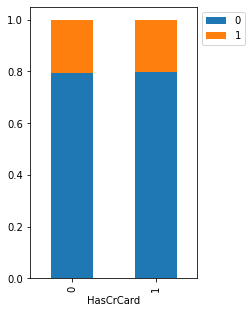

In [44]:
stacked_barplot(data=df, predictor='HasCrCard', target='Exited')

**Insights** 
- Exited customers does not vary according to HasCrCard

**IsActiveMember**

Exited             0     1    All
IsActiveMember                   
All             7963  2037  10000
0               3547  1302   4849
1               4416   735   5151
------------------------------------------------------------------------------------------------------------------------


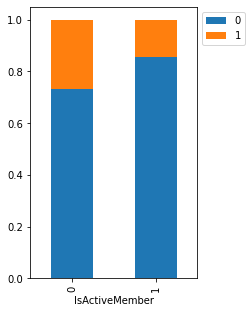

In [45]:
stacked_barplot(data=df, predictor='IsActiveMember', target='Exited')

**Insights**
- No active customers tend to leave the bank more often

**EstimatedSalary**

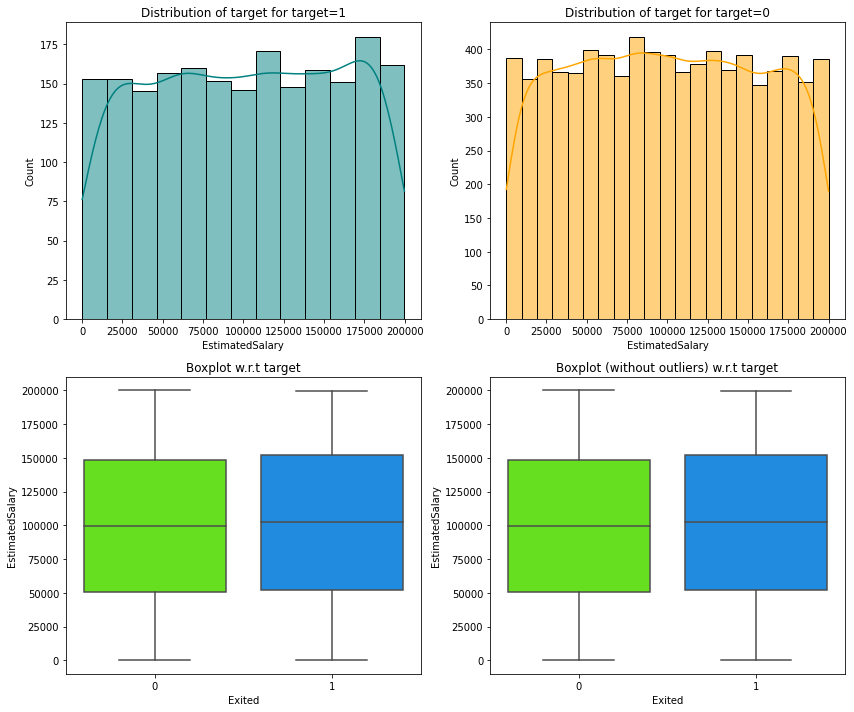

In [46]:
distribution_plot_wrt_target(data=df, predictor='EstimatedSalary', target='Exited')

**Insights**
- Exited customers are indifferent to the EstimatedSalary feature

# Data Processing

## Split the data

In [47]:
## Separating Independent and Dependent Columns
X = df.drop(['Exited'],axis=1)
Y = df[['Exited']]

In [48]:
Y.head()

,Exited
0,1
1,0
2,1
3,0
4,0


In [49]:
# Splitting the dataset into the Training and Testing set.

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify = Y)

## Encoding Categorical Columns

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [51]:
cat_cols = ['Geography','Gender','Tenure','NumOfProducts','HasCrCard','IsActiveMember']

In [52]:
labelencoder_Geo = LabelEncoder()
X_train['Geography']=  labelencoder_Geo.fit_transform(X_train['Geography'])
X_test['Geography']=  labelencoder_Geo.transform(X_test['Geography'])

In [53]:
labelencoder_Gen = LabelEncoder()
X_train['Gender']=  labelencoder_Gen.fit_transform(X_train['Gender'])
X_test['Gender']=  labelencoder_Gen.transform(X_test['Gender'])

In [54]:
labelencoder_Ten = LabelEncoder()
X_train['Tenure']=  labelencoder_Ten.fit_transform(X_train['Tenure'])
X_test['Tenure']=  labelencoder_Ten.transform(X_test['Tenure'])

In [55]:
labelencoder_Prod = LabelEncoder()
X_train['NumOfProducts']=  labelencoder_Prod.fit_transform(X_train['NumOfProducts'])
X_test['NumOfProducts']=  labelencoder_Prod.transform(X_test['NumOfProducts'])

In [56]:
labelencoder_HCr = LabelEncoder()
X_train['HasCrCard']=  labelencoder_HCr.fit_transform(X_train['HasCrCard'])
X_test['HasCrCard']=  labelencoder_HCr.transform(X_test['HasCrCard'])

In [57]:
labelencoder_AMem = LabelEncoder()
X_train['IsActiveMember']=  labelencoder_AMem.fit_transform(X_train['IsActiveMember'])
X_test['IsActiveMember']=  labelencoder_AMem.transform(X_test['IsActiveMember'])

## Standarizing Numerical Columns

In [58]:
num_cols = ['CreditScore','Age','Balance','EstimatedSalary']

In [59]:
sc_CS = StandardScaler()
temp = sc_CS.fit(X_train[["CreditScore"]])
X_train[["CreditScore"]] = temp.transform(X_train[["CreditScore"]])
X_test[["CreditScore"]] = temp.transform(X_test[["CreditScore"]])

In [60]:
sc_Age = StandardScaler()
temp = sc_Age.fit(X_train[["Age"]])
X_train[["Age"]] = temp.transform(X_train[["Age"]])
X_test[["Age"]] = temp.transform(X_test[["Age"]])

In [61]:
sc_Bal = StandardScaler()
temp = sc_Bal.fit(X_train[["Balance"]])
X_train[["Balance"]] = temp.transform(X_train[["Balance"]])
X_test[["Balance"]] = temp.transform(X_test[["Balance"]])

In [62]:
sc_ES = StandardScaler()
temp = sc_ES.fit(X_train[["EstimatedSalary"]])
X_train[["EstimatedSalary"]] = temp.transform(X_train[["EstimatedSalary"]])
X_test[["EstimatedSalary"]] = temp.transform(X_test[["EstimatedSalary"]])

In [63]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
2151,1.0586,0,1,1.7151,7,-1.2261,0,1,0,1.0421
8392,0.9136,1,1,-0.6599,3,0.4133,0,1,0,-0.6236
5006,1.0793,1,0,-0.1849,0,0.6017,1,1,1,0.3081
4117,-0.9292,0,1,-0.1849,5,-1.2261,1,1,0,-0.2902
7182,0.4270,1,1,0.9551,6,0.5483,1,0,1,0.1350


In [64]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 10)
(2000, 10)
(8000, 1)
(2000, 1)


# Model

## Metric to use

We have the following wrong prediction posibilities:
- **False Positive** (Predicted 1, Actual 0) that means that the model predicted that the customer will leave the bank but actually he did not. There is **no financial cost** for the bank in this case.
- **False Negative** (Predicted 0, Actual 1) the model predicted taht the customer will not leave the bank but in reality he did. **Financially this is disastrous** for the bank for the loos of the customer.

The **False Negatives** are a **bigger issue** than the **False Positives**. So the metric we will focuse on is **Recall Score**

## Model Building

### Model 1

In [65]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [66]:
model1 = Sequential()
model1.add(Dense(activation = 'relu', input_dim = 10, units=16))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation = 'sigmoid'))

In [67]:
model1.compile(optimizer='SGD', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])

In [68]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                176       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [69]:
history=model1.fit(X_train, y_train,           
          validation_split=0.2,
          epochs=50,
          batch_size=32,verbose=1)

Epoch 1/50
200/200 [==============================] - 1s 4ms/step - loss: 0.5162 - recall: 0.0023 - val_loss: 0.4896 - val_recall: 0.0000e+00
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4788 - recall: 7.6336e-04 - val_loss: 0.4674 - val_recall: 0.0188
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4581 - recall: 0.0229 - val_loss: 0.4561 - val_recall: 0.0469
Epoch 4/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4476 - recall: 0.0634 - val_loss: 0.4501 - val_recall: 0.0781
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4407 - recall: 0.1069 - val_loss: 0.4462 - val_recall: 0.1156
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 0.4373 - recall: 0.1450 - val_loss: 0.4445 - val_recall: 0.1500
Epoch 7/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4347 - recall: 0.1573 - val_loss: 0.4449 - val_recall: 0.2062
Epoch 8/50
200/200 [======

63/63 [==============================] - 0s 2ms/step - loss: 0.3973 - recall: 0.2752


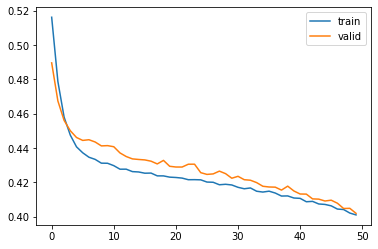

In [70]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

#Printing results
results = model1.evaluate(X_test, y_test)

In [71]:
y_pred=model1.predict(X_test)
y_pred = (y_pred > 0.5)
y_pred

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

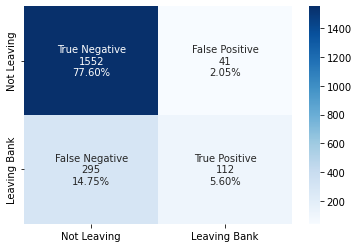

In [72]:
cm=confusion_matrix(y_test, y_pred)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = ['Not Leaving', 'Leaving Bank']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [73]:
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1593
           1       0.73      0.28      0.40       407

    accuracy                           0.83      2000
   macro avg       0.79      0.62      0.65      2000
weighted avg       0.82      0.83      0.80      2000



In [149]:
rs1 = recall_score(y_test, y_pred)
rs1

0.2751842751842752

As we can see our modell is underperforming, a **recall score** is way **low** on the **test data**

This might be caused by 2 thing:
1. Imbalanced data
2. Threshold we use

### Model 2


In [75]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [76]:
model2 = Sequential()
model2.add(Dense(32,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
model2.add(Dense(16,activation='relu',kernel_initializer='he_uniform'))
model2.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
model2.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=tf.keras.metrics.Recall())

In [77]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [78]:
history2 = model2.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.2)

Epoch 1/50
100/100 [==============================] - 1s 5ms/step - loss: 0.5020 - recall: 0.0947 - val_loss: 0.4656 - val_recall: 0.0719
Epoch 2/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4497 - recall: 0.1519 - val_loss: 0.4474 - val_recall: 0.1906
Epoch 3/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4389 - recall: 0.1817 - val_loss: 0.4367 - val_recall: 0.2344
Epoch 4/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4282 - recall: 0.2260 - val_loss: 0.4290 - val_recall: 0.2500
Epoch 5/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4233 - recall: 0.2351 - val_loss: 0.4234 - val_recall: 0.2406
Epoch 6/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4165 - recall: 0.2618 - val_loss: 0.4143 - val_recall: 0.2719
Epoch 7/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4119 - recall: 0.2740 - val_loss: 0.4078 - val_recall: 0.2906
Epoch 8/50
100/100 [==============

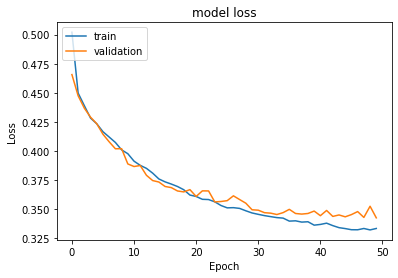

In [79]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 2ms/step
Best Threshold=0.204061, G-Mean=0.753


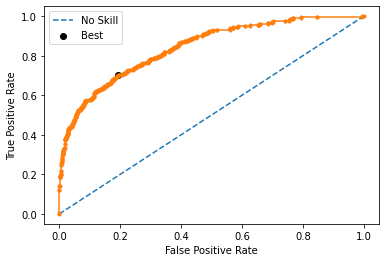

In [80]:
# predict probabilities
yhat2 = model2.predict(X_test)
# keep probabilities for the positive outcome only
yhat2 = yhat2[:, 0]
# calculate roc curves
fpr, tpr, thresholds2 = roc_curve(y_test, yhat2)
# calculate the g-mean for each threshold
gmeans2 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans2)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds2[ix], gmeans2[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [81]:
y_pred_e2=model2.predict(X_test)
y_pred_e2 = (y_pred_e2 > thresholds2[ix])
y_pred_e2

63/63 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

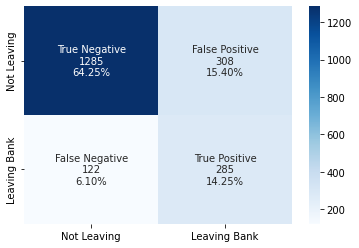

In [82]:
cm2=confusion_matrix(y_test, y_pred_e2)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = ['Not Leaving', 'Leaving Bank']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [83]:
cr2=metrics.classification_report(y_test,y_pred_e2)
print(cr2)

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      1593
           1       0.48      0.70      0.57       407

    accuracy                           0.79      2000
   macro avg       0.70      0.75      0.71      2000
weighted avg       0.83      0.79      0.80      2000



In [150]:
rs2 = recall_score(y_test, y_pred_e2)
rs2

0.7002457002457002

Changing the size of the neural network, using adam as an optimizer and using the best threshhold using ROC we have seen a significant improvement of our recall score. Lets see if we can do even better

### Model 3

In [85]:
# our first layer will have 32 nodes (#input + #output + 4[1-10])*2 = (10+2+4)*2 = 32
model3 = Sequential()
model3.add(Dense(32,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
model3.add(Dropout(0.2))
model3.add(Dense(16,activation='relu',kernel_initializer='he_uniform'))
model3.add(Dropout(0.2))
model3.add(Dense(8,activation='relu',kernel_initializer='he_uniform'))
model3.add(Dropout(0.2))
model3.add(Dense(4,activation='relu',kernel_initializer='he_uniform'))
model3.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
model3.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=tf.keras.metrics.Recall())

In [86]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                352       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_6 (Dense)             (None, 4)                

In [87]:
history3 = model3.fit(X_train,y_train,batch_size=64,epochs=50,verbose=1,validation_split = 0.2)

Epoch 1/50
100/100 [==============================] - 1s 5ms/step - loss: 0.5745 - recall_1: 0.0305 - val_loss: 0.5198 - val_recall_1: 0.0000e+00
Epoch 2/50
100/100 [==============================] - 0s 3ms/step - loss: 0.5259 - recall_1: 0.0038 - val_loss: 0.5004 - val_recall_1: 0.0000e+00
Epoch 3/50
100/100 [==============================] - 0s 3ms/step - loss: 0.5027 - recall_1: 0.0031 - val_loss: 0.4842 - val_recall_1: 0.0000e+00
Epoch 4/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4901 - recall_1: 0.0046 - val_loss: 0.4710 - val_recall_1: 0.0000e+00
Epoch 5/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4834 - recall_1: 7.6336e-04 - val_loss: 0.4660 - val_recall_1: 0.0000e+00
Epoch 6/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4750 - recall_1: 7.6336e-04 - val_loss: 0.4587 - val_recall_1: 0.0000e+00
Epoch 7/50
100/100 [==============================] - 0s 3ms/step - loss: 0.4662 - recall_1: 0.0000e+00 - val_loss: 

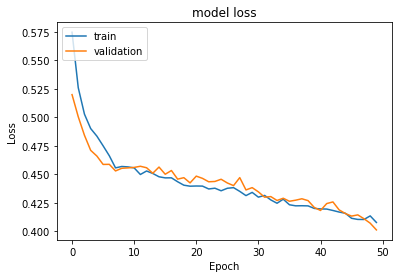

In [88]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 1ms/step
Best Threshold=0.268537, G-Mean=0.748


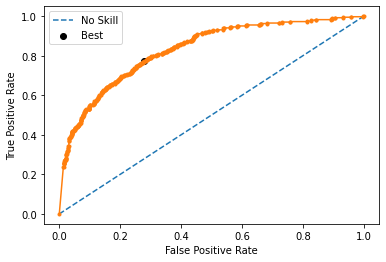

In [89]:
# predict probabilities
yhat3 = model3.predict(X_test)
# keep probabilities for the positive outcome only
yhat3 = yhat3[:, 0]
# calculate roc curves
fpr, tpr, thresholds3 = roc_curve(y_test, yhat3)
# calculate the g-mean for each threshold
gmeans3 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans3)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds3[ix], gmeans3[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [90]:
y_pred_e3=model3.predict(X_test)
y_pred_e3 = (y_pred_e3 > thresholds3[ix])
y_pred_e3

63/63 [==============================] - 0s 1ms/step


array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [False],
       [False]])

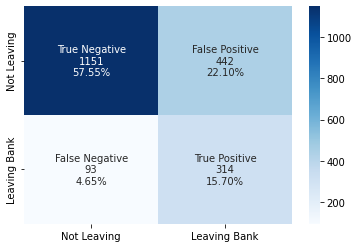

In [91]:
cm3=confusion_matrix(y_test, y_pred_e3)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = ['Not Leaving', 'Leaving Bank']
make_confusion_matrix(cm3, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [92]:
cr3=metrics.classification_report(y_test,y_pred_e3)
print(cr3)

              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1593
           1       0.42      0.77      0.54       407

    accuracy                           0.73      2000
   macro avg       0.67      0.75      0.68      2000
weighted avg       0.82      0.73      0.76      2000



In [151]:
rs3 = recall_score(y_test, y_pred_e3)
rs3

0.7714987714987716

Adding droput has slightly increased our recall score

### Model 4

In [94]:
!pip install dask-ml 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.5/148.5 KB 4.5 MB/s eta 0:00:00


In [95]:
from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV

In [96]:
def create_model_v6(lr,batch_size):  
    np.random.seed(1337)
    model = Sequential()
    model.add(Dense(256,activation='relu',input_dim = X_train.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = tf.keras.metrics.Recall())
    return model

In [97]:
keras_estimator = KerasClassifier(build_fn=create_model_v6, verbose=1)
# define the grid search parameters
param_grid = {
    'batch_size':[64,32, 128],
    "lr":[0.001,0.01,0.1],}

kfold_splits = 3
dask = DaskGridSearchCV(estimator=keras_estimator, 
                    cv=kfold_splits,  
                    param_grid=param_grid,n_jobs=-1,
                    scoring="recall")

In [98]:
# store starting time
begin = time.time()

dask_result = dask.fit(X_train, y_train,validation_split=0.2,verbose=1) 

# Summarize results
print("Best: %f using %s" % (dask_result.best_score_, dask_result.best_params_))
means = dask_result.cv_results_['mean_test_score']
stds = dask_result.cv_results_['std_test_score']
params = dask_result.cv_results_['params']

time.sleep(1)
# store end time
end = time.time()
  
# total time taken
print(f"Total runtime of the program is {end - begin}")

200/200 [==============================] - 2s 6ms/step - loss: 0.4750 - recall_13: 0.0221 - val_loss: 0.4459 - val_recall_13: 0.0000e+00
Best: 0.012938 using {'batch_size': 32, 'lr': 0.001}
Total runtime of the program is 80.32604193687439


This technique unfortunately did not sent a better result.
Lets try something else

### Model 5

In [99]:
backend.clear_session()
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [100]:
## Install Keras Tuner
!pip install keras-tuner 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.7 MB/s eta 0:00:00


In [101]:
from kerastuner.tuners import RandomSearch
import kerastuner

In [102]:
def build_model(h):
    model = keras.Sequential()
    for i in range(h.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=h.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=256,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            h.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=tf.keras.metrics.Recall())
    return model

In [103]:
tuner = RandomSearch(
    build_model,
    objective=kerastuner.Objective("recall", direction="max"),
    max_trials=5,
    executions_per_trial=3,
     project_name='Job_')

In [104]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [105]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_split = 0.2)

Trial 5 Complete [00h 00m 34s]
recall: 0.31552162766456604

Best recall So Far: 0.42010178168614704
Total elapsed time: 00h 02m 46s


This technique didnt performed bettwe than we have in past attempts.

### Model 6

In [106]:
smote=SMOTE(sampling_strategy='not majority')
X_sm , y_sm = smote.fit_resample(X_train,y_train)

In [107]:
X_train.shape

(8000, 10)

In [108]:
X_sm.shape

(12740, 10)

In [109]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [110]:
def build_model_2(h):
    model = keras.Sequential()
    for i in range(h.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=h.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=256,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            h.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=tf.keras.metrics.Recall())
    return model

In [111]:
tuner_2 = RandomSearch(
    build_model_2,
    objective=kerastuner.Objective("recall", direction="max"),
    max_trials=5,
    executions_per_trial=3,
    project_name='Job_Switch')

In [112]:
tuner_2.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [113]:
tuner_2.search(X_sm, y_sm,
             epochs=5,
             validation_split = 0.2)

Trial 5 Complete [00h 00m 57s]
recall: 0.6716378927230835

Best recall So Far: 0.7279783884684244
Total elapsed time: 00h 03m 42s


In [114]:
tuner_2.results_summary()

Results summary
Results in ./Job_Switch
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 160
units_1: 160
learning_rate: 0.001
units_2: 224
units_3: 128
units_4: 224
units_5: 64
units_6: 160
units_7: 64
units_8: 32
Score: 0.7279783884684244
Trial summary
Hyperparameters:
num_layers: 9
units_0: 192
units_1: 64
learning_rate: 0.001
units_2: 160
units_3: 32
units_4: 224
units_5: 32
units_6: 256
units_7: 96
units_8: 192
Score: 0.7224838733673096
Trial summary
Hyperparameters:
num_layers: 9
units_0: 224
units_1: 96
learning_rate: 0.001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
Score: 0.7058259050051371
Trial summary
Hyperparameters:
num_layers: 5
units_0: 32
units_1: 64
learning_rate: 0.01
units_2: 96
units_3: 256
units_4: 256
units_5: 160
units_6: 192
units_7: 224
units_8: 224
Score: 0.6787022550900778
Trial summary
Hyperparameters:
num_layers: 10
units_0: 128
units_1: 32
learning_rate: 0.0001
units_2: 160
units_3: 160
u

In [115]:
model6 = Sequential()
model6.add(Dense(160,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
model6.add(Dense(160,activation='relu',kernel_initializer='he_uniform'))
model6.add(Dense(224,activation='relu',kernel_initializer='he_uniform'))
model6.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model6.add(Dense(224,activation='relu',kernel_initializer='he_uniform'))
model6.add(Dense(1, activation = 'sigmoid'))
 
optimizer = tf.keras.optimizers.Adam(0.001)
model6.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=tf.keras.metrics.Recall())

In [116]:
model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 160)               1760      
                                                                 
 dense_12 (Dense)            (None, 160)               25760     
                                                                 
 dense_13 (Dense)            (None, 224)               36064     
                                                                 
 dense_14 (Dense)            (None, 128)               28800     
                                                                 
 dense_15 (Dense)            (None, 224)               28896     
                                                                 
 dense_16 (Dense)            (None, 1)                 225       
                                                                 
Total params: 121,505
Trainable params: 121,505
Non-tr

In [117]:
history_6 = model6.fit(X_sm,y_sm,batch_size=64,epochs=50,verbose=1,validation_split = 0.2)

Epoch 1/50
160/160 [==============================] - 2s 9ms/step - loss: 0.5295 - recall_1: 0.5704 - val_loss: 0.5857 - val_recall_1: 0.6825
Epoch 2/50
160/160 [==============================] - 1s 7ms/step - loss: 0.4521 - recall_1: 0.6507 - val_loss: 0.9508 - val_recall_1: 0.5338
Epoch 3/50
160/160 [==============================] - 1s 7ms/step - loss: 0.4239 - recall_1: 0.6866 - val_loss: 0.5754 - val_recall_1: 0.6974
Epoch 4/50
160/160 [==============================] - 1s 7ms/step - loss: 0.4030 - recall_1: 0.6957 - val_loss: 0.3758 - val_recall_1: 0.8214
Epoch 5/50
160/160 [==============================] - 1s 7ms/step - loss: 0.3971 - recall_1: 0.7227 - val_loss: 0.5870 - val_recall_1: 0.6699
Epoch 6/50
160/160 [==============================] - 1s 7ms/step - loss: 0.3837 - recall_1: 0.7088 - val_loss: 0.3829 - val_recall_1: 0.8297
Epoch 7/50
160/160 [==============================] - 1s 7ms/step - loss: 0.3757 - recall_1: 0.7282 - val_loss: 0.4916 - val_recall_1: 0.7394
Epoch 

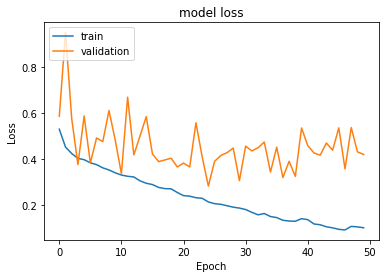

In [118]:
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 2ms/step
Best Threshold=0.063013, G-Mean=0.720


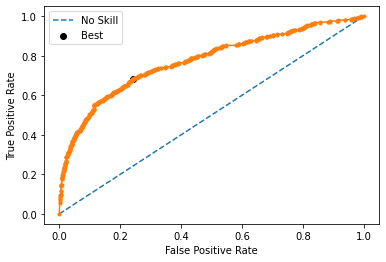

In [119]:
# predict probabilities
yhat6 = model6.predict(X_test)
# keep probabilities for the positive outcome only
yhat6 = yhat6[:, 0]
# calculate roc curves
fpr, tpr, thresholds6 = roc_curve(y_test, yhat6)
# calculate the g-mean for each threshold
gmeans6 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans6)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds6[ix], gmeans6[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [120]:
y_pred_e6=model6.predict(X_test)
y_pred_e6 = (y_pred_e6 > thresholds6[ix])
y_pred_e6

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

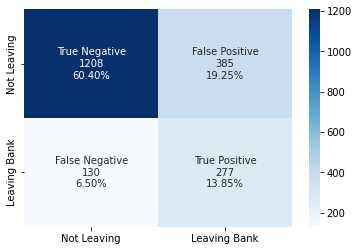

In [121]:
cm6=confusion_matrix(y_test, y_pred_e6)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = ['Not Leaving', 'Leaving Bank']
make_confusion_matrix(cm6, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [122]:
cr6=metrics.classification_report(y_test,y_pred_e6)
print(cr6)

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1593
           1       0.42      0.68      0.52       407

    accuracy                           0.74      2000
   macro avg       0.66      0.72      0.67      2000
weighted avg       0.80      0.74      0.76      2000



In [152]:
rs6 = recall_score(y_test, y_pred_e6)
rs6

0.6805896805896806

After applying the SMOTE technique to the data, the recall score is not bad but is not the best we have, the model seems to have overfit.

### Model 7

In [124]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [125]:
def create_model_v7(lr,batch_size):  
    np.random.seed(1337)
    model = Sequential()
    model.add(Dense(256,activation='relu',input_dim = X_train.shape[1]))
    model.add(Dropout(0.3))
    #model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    #model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
    #model.add(Dropout(0.3))
    model.add(Dense(32,activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = tf.keras.metrics.Recall())
    return model

In [126]:
keras_estimator = KerasClassifier(build_fn=create_model_v7, verbose=1)

In [127]:
# define the grid search parameters
param_grid = {
    'batch_size':[32, 64, 128],
    "lr":[0.001,0.01,0.1],}

kfold_splits = 3
grid = GridSearchCV(estimator=keras_estimator,  
                    verbose=1,
                    cv=kfold_splits,  
                    param_grid=param_grid,n_jobs=-1,
                    scoring="recall")
grid_result = grid.fit(X_train, y_train,validation_split=0.2,verbose=1) 

Fitting 3 folds for each of 9 candidates, totalling 27 fits
200/200 [==============================] - 2s 6ms/step - loss: 0.4663 - recall: 0.0313 - val_loss: 0.4474 - val_recall: 0.0000e+00


In [128]:
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.061168 using {'batch_size': 32, 'lr': 0.01}


In [129]:
estimator_v7=create_model_v7(batch_size=grid_result.best_params_['batch_size'],lr=grid_result.best_params_['lr'])

estimator_v7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               2816      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [130]:
optimizer = tf.keras.optimizers.Adam(grid_result.best_params_['lr'])
estimator_v7.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=tf.keras.metrics.Recall())
history_7=estimator_v7.fit(X_sm, y_sm, epochs=50, batch_size = grid_result.best_params_['batch_size'], verbose=1,validation_split=0.2)

Epoch 1/50
319/319 [==============================] - 3s 5ms/step - loss: 0.5466 - recall_2: 0.5209 - val_loss: 0.5789 - val_recall_2: 0.6138
Epoch 2/50
319/319 [==============================] - 1s 4ms/step - loss: 0.4793 - recall_2: 0.5819 - val_loss: 0.8028 - val_recall_2: 0.5098
Epoch 3/50
319/319 [==============================] - 1s 4ms/step - loss: 0.4655 - recall_2: 0.6115 - val_loss: 0.5666 - val_recall_2: 0.7261
Epoch 4/50
319/319 [==============================] - 1s 4ms/step - loss: 0.4538 - recall_2: 0.6285 - val_loss: 0.5937 - val_recall_2: 0.6268
Epoch 5/50
319/319 [==============================] - 1s 4ms/step - loss: 0.4535 - recall_2: 0.6402 - val_loss: 0.5983 - val_recall_2: 0.6209
Epoch 6/50
319/319 [==============================] - 1s 4ms/step - loss: 0.4437 - recall_2: 0.6376 - val_loss: 0.4751 - val_recall_2: 0.7594
Epoch 7/50
319/319 [==============================] - 1s 4ms/step - loss: 0.4417 - recall_2: 0.6701 - val_loss: 0.5750 - val_recall_2: 0.7241
Epoch 

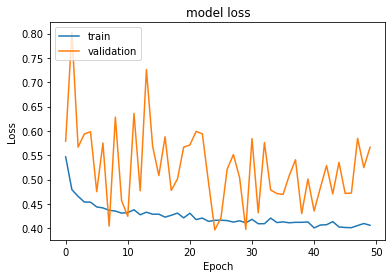

In [131]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_7.history['loss'])
plt.plot(history_7.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 2ms/step
Best Threshold=0.417029, G-Mean=0.757


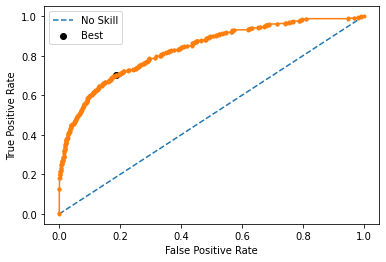

In [132]:
# predict probabilities
yhat7 = estimator_v7.predict(X_test)
# keep probabilities for the positive outcome only
yhat7 = yhat7[:, 0]
# calculate roc curves
fpr, tpr, thresholds7 = roc_curve(y_test, yhat7)
# calculate the g-mean for each threshold
gmeans7 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans7)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds7[ix], gmeans7[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [133]:
y_pred_e7=estimator_v7.predict(X_test)
y_pred_e7 = (y_pred_e7 > thresholds7[ix])
y_pred_e7

63/63 [==============================] - 0s 1ms/step


array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [False],
       [False]])

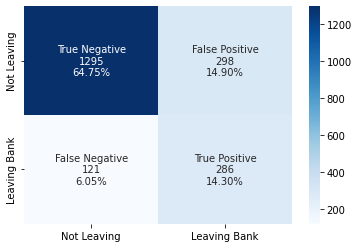

In [134]:
cm7=confusion_matrix(y_test, y_pred_e7)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = ['Not Leaving', 'Leaving Bank']
make_confusion_matrix(cm7, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [135]:
cr7=metrics.classification_report(y_test,y_pred_e7)
print(cr7)

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      1593
           1       0.49      0.70      0.58       407

    accuracy                           0.79      2000
   macro avg       0.70      0.76      0.72      2000
weighted avg       0.83      0.79      0.80      2000



In [153]:
rs7 = recall_score(y_test, y_pred_e7)
rs7

0.7027027027027027

This was not a bad performance but our model 3 is still the best.

### Model 8

Lets try one last thing.
Lets run a model exactly the same as model 3 but with oversampled data

In [137]:
# our first layer will have 32 nodes (#input + #output + 4[1-10])*2 = (10+2+4)*2 = 32
model8 = Sequential()
model8.add(Dense(32,activation='relu',kernel_initializer='he_uniform',input_dim = X_train.shape[1]))
model8.add(Dropout(0.2))
model8.add(Dense(16,activation='relu',kernel_initializer='he_uniform'))
model8.add(Dropout(0.2))
model8.add(Dense(8,activation='relu',kernel_initializer='he_uniform'))
model8.add(Dropout(0.2))
model8.add(Dense(4,activation='relu',kernel_initializer='he_uniform'))
model8.add(Dense(1, activation = 'sigmoid'))
optimizer = tf.keras.optimizers.Adam(0.001)
model8.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=tf.keras.metrics.Recall())

In [138]:
model8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                352       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_13 (Dense)            (None, 4)                

In [139]:
#we will train with obersampled data
history8 = model8.fit(X_sm,y_sm,batch_size=64,epochs=50,verbose=1,validation_split = 0.2)

Epoch 1/50
160/160 [==============================] - 2s 5ms/step - loss: 0.6649 - recall_3: 0.1054 - val_loss: 0.8107 - val_recall_3: 0.0000e+00
Epoch 2/50
160/160 [==============================] - 1s 3ms/step - loss: 0.6286 - recall_3: 0.0395 - val_loss: 0.8183 - val_recall_3: 0.0020
Epoch 3/50
160/160 [==============================] - 1s 3ms/step - loss: 0.6060 - recall_3: 0.1737 - val_loss: 0.7873 - val_recall_3: 0.6421
Epoch 4/50
160/160 [==============================] - 1s 4ms/step - loss: 0.5844 - recall_3: 0.4890 - val_loss: 0.8164 - val_recall_3: 0.6264
Epoch 5/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5794 - recall_3: 0.5678 - val_loss: 0.7863 - val_recall_3: 0.6401
Epoch 6/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5709 - recall_3: 0.5604 - val_loss: 0.7031 - val_recall_3: 0.6849
Epoch 7/50
160/160 [==============================] - 1s 3ms/step - loss: 0.5651 - recall_3: 0.5853 - val_loss: 0.7160 - val_recall_3: 0.6621
Ep

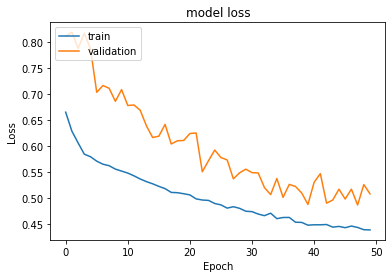

In [140]:
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

63/63 [==============================] - 0s 1ms/step
Best Threshold=0.268537, G-Mean=0.748


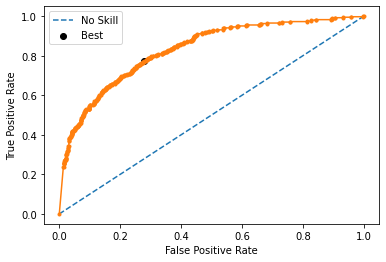

In [141]:
# predict probabilities
yhat8 = model8.predict(X_test)
# keep probabilities for the positive outcome only
yhat8 = yhat8[:, 0]
# calculate roc curves
fpr, tpr, thresholds8 = roc_curve(y_test, yhat3)
# calculate the g-mean for each threshold
gmeans8 = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans8)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds8[ix], gmeans8[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [142]:
y_pred_e8=model8.predict(X_test)
y_pred_e8 = (y_pred_e8 > thresholds8[ix])
y_pred_e8

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

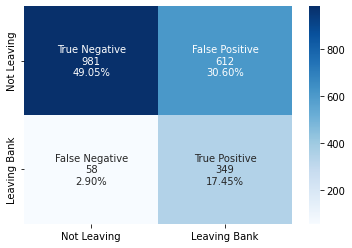

In [143]:
cm8=confusion_matrix(y_test, y_pred_e8)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = ['Not Leaving', 'Leaving Bank']
make_confusion_matrix(cm8, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

In [144]:
cr8=metrics.classification_report(y_test,y_pred_e8)
print(cr8)

              precision    recall  f1-score   support

           0       0.94      0.62      0.75      1593
           1       0.36      0.86      0.51       407

    accuracy                           0.67      2000
   macro avg       0.65      0.74      0.63      2000
weighted avg       0.83      0.67      0.70      2000



In [154]:
rs8 = recall_score(y_test, y_pred_e8)
rs8

0.8574938574938575

This model is by far the best we did!!

# Model Selection

In [156]:
models = ['Model 1','Model 2','Model 3','Model 6','Model 7','Model 8']
recall_scores = [rs1*100, rs2*100, rs3*100, rs6*100, rs7*100, rs8*100]
comparison = pd.DataFrame()
comparison["Model"] = models
comparison["Recall Score"] = recall_scores
comparison

,Model,Recall Score
0,Model 1,27.5184
1,Model 2,70.0246
2,Model 3,77.1499
3,Model 6,68.0590
4,Model 7,70.2703
5,Model 8,85.7494


The best Model is model 8

# Actionable Insights & Recommendations

## Cumulative gain plot

In [146]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


63/63 [==============================] - 0s 1ms/step


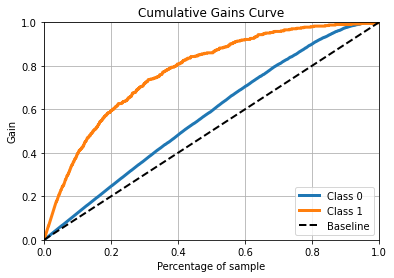

In [147]:
import scikitplot as skplt
# Deriving Class probabilities
#predicted_probabilities = model8.predict_proba(X_test)
y_pred_e8a = model8.predict(X_test)
y_pred_e8a = np.concatenate((1-y_pred_e8a,y_pred_e8a),axis=1)
# Creating the plot
skplt.metrics.plot_cumulative_gain(y_test, y_pred_e8a)

**Insights and recomendations**

From the EDA
- German customers tend to leave the bank more often than spanish or french ones
- Female customers leave the bank more often than males
- New customers tend to leave the bank a little more often than customers with more years of relation with the bank
- Customers who exited the bank had higher balance than thos who stayed
- 100% of customers with 4 products leave the bank
- 82% of customers with 3 products leave the bank
- More than 90% of customers with only 1 product did not leave the bank
- No active customers tend to leave the bank more often

Business recommendations
- We can see in the gain plot that contacting the 20% of our client database we can reach as high as 60% of the clients who might attrite
- Marketing and Product department should work together to make a contact campaign, taking in consideration the findings in the EDA and contact 20% of our customers

# Convert ipynb to HTML



In [157]:
%%shell
jupyter nbconvert --to html ///content/Project_7_Deep_Neural_Network_Bank_Churn_Prediction_EMS.ipynb

[NbConvertApp] Converting notebook ///content/Project_7_Deep_Neural_Network_Bank_Churn_Prediction_EMS.ipynb to html
[NbConvertApp] Writing 2332780 bytes to ///content/Project_7_Deep_Neural_Network_Bank_Churn_Prediction_EMS.html
